<h1><center> Drug Reviews - Sentiment Analysis </center></h1>

As we saw in the EDA, we have a bimodal distribution of the ratings. This is common in review data as customers (in this case patients) are more likely to write reviews when they have either a very positive, or a very negative experience. What can we learn by looking at the sentiment? 

In [1]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS


import warnings
warnings.filterwarnings('ignore')

# Regex library to clean data 
import re, string, gc  

# pretty printing for better legibility
import pprint

# Natural Language Tool Kit 
import nltk  
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# Vader Sentiment Analysis Tool
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Web Scrapping Clearner
from bs4 import BeautifulSoup

# Progress bar
from tqdm import tqdm, tqdm_notebook
# Instantiate
tqdm.pandas(tqdm_notebook)

In [2]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import log_loss, confusion_matrix, classification_report, roc_curve,auc, accuracy_score, recall_score
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from sklearn.svm import SVC
from sklearn import svm
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Load in the CSV file that was created at the end of the EDA notebook
bigdata = pd.read_csv('bigdata_eda.csv', index_col = 0)

In [4]:
# USING VADER SENTIMENT TO PREDICT THE RATING 

In [5]:
analyzer = SentimentIntensityAnalyzer()

sentiments = []

#Note that vader's lexicon is designed to remove stopwords, punctuation, numbers, accents, etc. Let's see!
for i in bigdata.review:
    sentiments.append(analyzer.polarity_scores(i).get('compound'))
    
sentiments = np.array(sentiments)

In [6]:
bigdata['vader_sentiment_score'] = sentiments
bigdata = bigdata.sort_values(by='usefulCount', ascending=False).reset_index(drop=True)
bigdata.head()

,drugName,condition,review,rating,date,usefulCount,day,month,year,pop_w_cond,total_users,vader_sentiment_score
0,Sertraline,Depression,"""I remember reading people&#039;s opinions, on...",10,2008-07-31,1291,31,7,2008,7112,1296,0.9772
1,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10,2009-04-01,1247,1,4,2009,19525,830,0.7739
2,Zoloft,Depression,"""I&#039;ve been on Zoloft 50mg for over two ye...",9,2008-08-05,949,5,8,2008,7112,563,-0.6815
3,Adipex-P,Weight Loss,"""I have used this pill off and on for the past...",10,2008-10-19,796,19,10,2008,3111,237,0.7921
4,Citalopram,Depression,"""I responded after one week. The side effects ...",8,2008-03-25,771,25,3,2008,7112,1003,-0.7227


In [7]:
# Note that despite the high ratings that are appearing in the head with the top usefulCount, we still have 
# some negative sentiment scores.

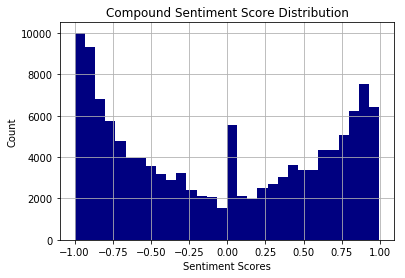

In [8]:
bigdata.vader_sentiment_score.hist(color='navy', bins=30)
plt.title('Compound Sentiment Score Distribution')
plt.xlabel('Sentiment Scores')
plt.ylabel('Count');

In [9]:
# It is is interesting to note that despite having way more positive ratings, in our data set, it appears like
# we have more negative sentiments.

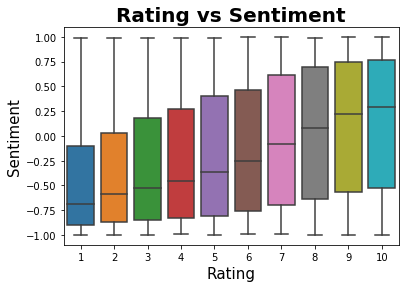

In [10]:
sns.boxplot(x = bigdata.rating, y = bigdata.vader_sentiment_score)
plt.title('Rating vs Sentiment', fontweight='bold', size=20)
plt.xlabel('Rating', size=15)
plt.ylabel('Sentiment', size=15)
plt.show()

In [11]:
# For each rating, we still found both positive and negative sentiments. This sentiment analysis is more geared 
# toward finding negative snetiments, which makes sense based on the histogram. 

# We can see that the median for the lower sentiments is stronger for negative ratings (means between -.5 and -.75). 
# However the median of the most positive ratings (9 and 10) which are between 0 and .25. 

# Also the variance (the size of each box) increases as we become more positive in rating. Notice that the sentiment
# for 1 is never greater thna 0. However, for 10, the variance is from -.5 to +.75.

In [12]:
positive_num = len(bigdata[bigdata['vader_sentiment_score'] >=0.05])
neutral_num = len(bigdata[(bigdata['vader_sentiment_score'] >-0.05) & (bigdata['vader_sentiment_score']<0.05)])
negative_num = len(bigdata[bigdata['vader_sentiment_score']<=-0.05])

print(positive_num, neutral_num, negative_num)

57121 6120 64686


In [13]:
bigdata['vader_sentiment_label']= bigdata['vader_sentiment_score'].apply(lambda x:str('positive') if x>=0.05 else str('negative') if x<=-0.05 else str('neutral'))

In [14]:
bigdata['pos-neg-rating'] = bigdata['rating'].apply(lambda x:str('positive') if x>=9 else str('negative'))
bigdata.head()

,drugName,condition,review,rating,date,usefulCount,day,month,year,pop_w_cond,total_users,vader_sentiment_score,vader_sentiment_label,pos-neg-rating
0,Sertraline,Depression,"""I remember reading people&#039;s opinions, on...",10,2008-07-31,1291,31,7,2008,7112,1296,0.9772,positive,positive
1,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10,2009-04-01,1247,1,4,2009,19525,830,0.7739,positive,positive
2,Zoloft,Depression,"""I&#039;ve been on Zoloft 50mg for over two ye...",9,2008-08-05,949,5,8,2008,7112,563,-0.6815,negative,positive
3,Adipex-P,Weight Loss,"""I have used this pill off and on for the past...",10,2008-10-19,796,19,10,2008,3111,237,0.7921,positive,positive
4,Citalopram,Depression,"""I responded after one week. The side effects ...",8,2008-03-25,771,25,3,2008,7112,1003,-0.7227,negative,negative


In [15]:
bigdata['pos-neg-bin'] = bigdata['rating'].apply(lambda x:int('1') if x>=9 else int('0'))
bigdata.head()

,drugName,condition,review,rating,date,usefulCount,day,month,year,pop_w_cond,total_users,vader_sentiment_score,vader_sentiment_label,pos-neg-rating,pos-neg-bin
0,Sertraline,Depression,"""I remember reading people&#039;s opinions, on...",10,2008-07-31,1291,31,7,2008,7112,1296,0.9772,positive,positive,1
1,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10,2009-04-01,1247,1,4,2009,19525,830,0.7739,positive,positive,1
2,Zoloft,Depression,"""I&#039;ve been on Zoloft 50mg for over two ye...",9,2008-08-05,949,5,8,2008,7112,563,-0.6815,negative,positive,1
3,Adipex-P,Weight Loss,"""I have used this pill off and on for the past...",10,2008-10-19,796,19,10,2008,3111,237,0.7921,positive,positive,1
4,Citalopram,Depression,"""I responded after one week. The side effects ...",8,2008-03-25,771,25,3,2008,7112,1003,-0.7227,negative,negative,0


In [16]:
bigdata['pos-neg-rating'].value_counts() 
# There are two equal sized classes. Based on a marketing technique called the netpromoter score I decided that
# anything which is a 9 or 10 is positive. While 7 or 8 are often considered passive/neutral, I will call anything
# below 9 as a negative as that is what we saw in the vader sentiment. 

negative    65479
positive    62448
Name: pos-neg-rating, dtype: int64

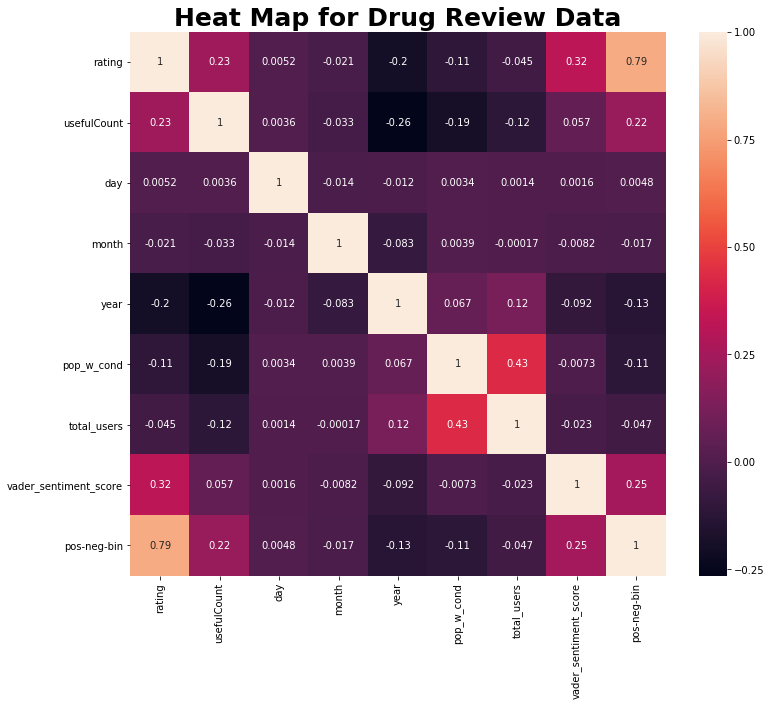

In [17]:
corr = bigdata.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot = True)
plt.xticks(rotation = 90)
plt.title("Heat Map for Drug Review Data",  fontweight="bold", size=25)
plt.show();

In [18]:
# I wanted to see what the relationship is for sentiment and rating. As shown in the heat map above, it has a
# correlation coefficient of 0.32.

In [19]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"(\d)", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),;!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    return df

bigdata = standardize_text(bigdata, "review")

In [20]:
bigdata.head(5)

,drugName,condition,review,rating,date,usefulCount,day,month,year,pop_w_cond,total_users,vader_sentiment_score,vader_sentiment_label,pos-neg-rating,pos-neg-bin
0,Sertraline,Depression,"""I remember reading people ;s opinions, onlin...",10,2008-07-31,1291,31,7,2008,7112,1296,0.9772,positive,positive,1
1,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10,2009-04-01,1247,1,4,2009,19525,830,0.7739,positive,positive,1
2,Zoloft,Depression,"""I ;ve been on Zoloft mg for over two years ...",9,2008-08-05,949,5,8,2008,7112,563,-0.6815,negative,positive,1
3,Adipex-P,Weight Loss,"""I have used this pill off and on for the past...",10,2008-10-19,796,19,10,2008,3111,237,0.7921,positive,positive,1
4,Citalopram,Depression,"""I responded after one week The side effects ...",8,2008-03-25,771,25,3,2008,7112,1003,-0.7227,negative,negative,0


In [21]:
# Create StopWords List
stoplist = stopwords.words('english')

from nltk.corpus import stopwords
stoplist = stopwords.words('english')
# Let's extend the stoplist to account for other commonly occuring words in the text.
stoplist.extend(['from', 'mg', 'ive', 'doctor', 'doc', 'pill', 'quot', 're','use','one', 'br', 'po', 'th', 'sayi', 'fo', 'unknown', 'take', 'take', 'taken,' 'get' ])
len(stoplist)

198

In [22]:
# Words with the contraction, not are very useful in sentiment analysis
not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stoplist.remove(i)
len(stoplist)

178

In [23]:
def review_to_wordlist( review, remove_stopwords=False ):
    # Remove HTML
    review_text = BeautifulSoup(review).get_text()
    # Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    # Convert words to lower case and split them
    words = review_text.lower().split()
    # Optionally remove stop words (false by default) # I am going to use my previously defined stoplist
    if remove_stopwords:
        words = [w for w in words if not w in stoplist]
    # Return a list of words
    return(' '.join(words))

In [24]:
bigdata['drugs'] = bigdata['drugName'].progress_apply(review_to_wordlist)

100%|██████████| 127927/127927 [00:32<00:00, 3981.67it/s]


In [25]:
# Let's scrub the reviews and use stemming

In [26]:
stemmer = SnowballStemmer('english')
def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 4. Stopwords 
    meaningful_words = [w for w in words if not w in stoplist]
    # 5. Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 6. space join words
    return( ' '.join(stemming_words))

In [27]:
bigdata['review_stemmed'] = bigdata['review'].progress_apply(review_to_words)

100%|██████████| 127927/127927 [02:05<00:00, 1021.56it/s]


In [28]:
bigdata.head()

,drugName,condition,review,rating,date,usefulCount,day,month,year,pop_w_cond,total_users,vader_sentiment_score,vader_sentiment_label,pos-neg-rating,pos-neg-bin,drugs,review_stemmed
0,Sertraline,Depression,"""I remember reading people ;s opinions, onlin...",10,2008-07-31,1291,31,7,2008,7112,1296,0.9772,positive,positive,1,sertraline,rememb read peopl opinion onlin drug took scar...
1,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10,2009-04-01,1247,1,4,2009,19525,830,0.7739,positive,positive,1,mirena,iud year think best thing ever first got put b...
2,Zoloft,Depression,"""I ;ve been on Zoloft mg for over two years ...",9,2008-08-05,949,5,8,2008,7112,563,-0.6815,negative,positive,1,zoloft,zoloft two year relax easi go person zoloft pr...
3,Adipex-P,Weight Loss,"""I have used this pill off and on for the past...",10,2008-10-19,796,19,10,2008,3111,237,0.7921,positive,positive,1,adipex p,use past year say best lose weight thing ever ...
4,Citalopram,Depression,"""I responded after one week The side effects ...",8,2008-03-25,771,25,3,2008,7112,1003,-0.7227,negative,negative,0,citalopram,respond week side effect lethargi bowel proble...


In [29]:
def review_to_wordlist( condition, remove_stopwords=False ):
    # Remove HTML
    review_text = BeautifulSoup(condition).get_text()
    # Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    # Convert words to lower case and split them
    words = review_text.lower().split()
    # Optionally remove stop words (false by default) # I am going to use my previously defined stoplist
    if remove_stopwords:
        words = [w for w in words if not w in stoplist]
    # Return a list of words
    return(' '.join(words))

In [30]:
bigdata['clean_condition'] = bigdata['condition'].progress_apply(review_to_wordlist)

100%|██████████| 127927/127927 [00:28<00:00, 4493.23it/s]


In [31]:
len(bigdata[bigdata.clean_condition.str.contains("</span> users found this comment helpful")])

0

In [33]:
bigdata.to_csv("bigdata_clean.csv")

### Vader Analysis

In [34]:
X = bigdata[["vader_sentiment_score"]]
y = bigdata['pos-neg-bin']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=.25, random_state=42)

# First we set up our pipeline for analysis


scaler = StandardScaler()
logreg = LogisticRegression()
estimators = [('scaler', scaler) , ('logreg', logreg)]

# Create our actual pipeline

pipe = Pipeline(estimators)

# Now we set up our grid search
params = {'logreg__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
         'logreg__solver': ['saga', 'liblinear'],
         'logreg__penalty': ['l1','l2'] }
# Instantiate our grid searcher
grid_search = GridSearchCV(pipe, param_grid = params, scoring = 'f1', cv=5, verbose=True)
# Fit our searcher to our data
fitted_search = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   46.9s finished


In [35]:
from sklearn.metrics import f1_score
# Look at the hyperparameters it found
display(fitted_search.best_estimator_)
# Calculate its predicted values on our test set
y_pred = fitted_search.best_estimator_.predict(X_test)
# Look at some evaluations metrics
print('f1:', f1_score(y_test, y_pred))
print('Confusion mattrix:\n', confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logreg', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])

f1: 0.598404085541015
Confusion mattrix:
 [[10026  6368]
 [ 6214  9374]]
              precision    recall  f1-score   support

           0       0.62      0.61      0.61     16394
           1       0.60      0.60      0.60     15588

   micro avg       0.61      0.61      0.61     31982
   macro avg       0.61      0.61      0.61     31982
weighted avg       0.61      0.61      0.61     31982



In [36]:
X = bigdata[["vader_sentiment_score"]]
y = bigdata['pos-neg-bin']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=.25, random_state=42)

# First we set up our pipeline for analysis


rfc=RandomForestClassifier(random_state=42)


# Now we set up our grid search
params = {      
                'n_estimators': [300,400,500],
                'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth' : [5,6,7,8],
                'criterion' : ['gini', 'entropy']
         }

CV_rfc = GridSearchCV(estimator=rfc, param_grid=params, cv= 5, verbose=5, n_jobs= -1)

CV_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 26.5min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 49.8min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 66.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [300, 400, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [5, 6, 7, 8], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [37]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 300}

In [38]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 300, 
                            max_depth=8, criterion='entropy')

rfc1.fit(X_train, y_train)

y_pred=rfc1.predict(X_test)

print("F1_Score for Random Forest on CV data: ",f1_score(y_test,y_pred))
print('Confusion mattrix:\n', confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

F1_Score for Random Forest on CV data:  0.570672349786883
Confusion mattrix:
 [[11191  5203]
 [ 7287  8301]]
              precision    recall  f1-score   support

           0       0.61      0.68      0.64     16394
           1       0.61      0.53      0.57     15588

   micro avg       0.61      0.61      0.61     31982
   macro avg       0.61      0.61      0.61     31982
weighted avg       0.61      0.61      0.61     31982



Logically it makes sense to me that sentiment alone isn't able to predict rating with tremendous accuracy. 
When people provide reviews, words don't always equal numbers, and numbers don't equal words. 

A key takeaway for me is that while we have a bi-modal distribution of ratings (which is a common situation), 
that their ratings are really low , or really high. We can use sentiment analysis to figure out how people feel 
and not just the high rating or low rating. What is someone who gives a 6-8 score really saying about their experience through their statements. 

In [39]:
# What happens if we we add some more features?

In [40]:
X = bigdata[["vader_sentiment_score", "usefulCount", "year", "pop_w_cond", "total_users"]]
y = bigdata['pos-neg-bin']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=.25, random_state=42)

# First we set up our pipeline for analysis

from sklearn.pipeline import Pipeline
scaler = StandardScaler()
logreg = LogisticRegression()

estimators = [('scaler', scaler) , ('logreg', logreg)]

# Create our actual pipeline

pipe = Pipeline(estimators)

# Now we set up our grid search
params = {'logreg__C': [0.001, 0.01, 0.1, 1, 5, 10, 100, 1000, 10000],
         'logreg__solver': ['saga', 'liblinear'],
         'logreg__penalty': ['l1','l2'] }
# Instantiate our grid searcher
grid_search = GridSearchCV(pipe, param_grid = params, scoring = 'f1', cv=5, verbose=True)
# Fit our searcher to our data
fitted_search = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   51.6s finished


In [41]:
# Look at the hyperparameters it found
display(fitted_search.best_estimator_)
# Calculate its predicted values on our test set
y_pred = fitted_search.best_estimator_.predict(X_test)
# Look at some evaluations metrics
print('F1:', f1_score(y_test, y_pred))
print('Confusion mattrix:\n', confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logreg', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])

F1: 0.637788726086122
Confusion mattrix:
 [[10692  5702]
 [ 5620  9968]]
              precision    recall  f1-score   support

           0       0.66      0.65      0.65     16394
           1       0.64      0.64      0.64     15588

   micro avg       0.65      0.65      0.65     31982
   macro avg       0.65      0.65      0.65     31982
weighted avg       0.65      0.65      0.65     31982



In [42]:
X = bigdata[["vader_sentiment_score", "usefulCount", "year", "pop_w_cond", "total_users"]]
y = bigdata['pos-neg-bin']


X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=.25, random_state=42)
rfc_rating = RandomForestClassifier(n_estimators=300, random_state=42, max_depth = 300, 
                                    min_samples_split=0.1, n_jobs= -1, verbose=1)
rfc_rating.fit(X_train, y_train)

# Evaluates model on test set
y_pred = rfc_rating.predict(X_test)

print("Accuracy:",  rfc_rating.score(X_test, y_test))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.3s finished


Accuracy: 0.6490213244950285
Confusion Matrix
[[10357  6037]
 [ 5188 10400]]
              precision    recall  f1-score   support

           0       0.67      0.63      0.65     16394
           1       0.63      0.67      0.65     15588

   micro avg       0.65      0.65      0.65     31982
   macro avg       0.65      0.65      0.65     31982
weighted avg       0.65      0.65      0.65     31982



In [43]:
# Unfortunately, my models are struggling to have scores over 70%. Later on, I will see if I can do better using 
# word vectors rather than sentiment! 

In [44]:
# However, that doesn't mean that there isn't value that can be extracted by medical professionals.
# I am curious, what drugs for each condition, have the highest sentiment. 

In [46]:
new_df = bigdata[["clean_condition", "drugs", "vader_sentiment_score", "rating"]]
new_df.head()

,clean_condition,drugs,vader_sentiment_score,rating
0,depression,sertraline,0.9772,10
1,birth control,mirena,0.7739,10
2,depression,zoloft,-0.6815,9
3,weight loss,adipex p,0.7921,10
4,depression,citalopram,-0.7227,8


#### In order to understand how drugs compared between sentiment and rating, I need to replace the cases of the generic with the brand name.

In [47]:
replaceDict =     [('Zoloft', 'Sertraline'),
                   ('Prozac','Fluoxetine'), 
                   ('Implanon', 'Etonogestrel' ),
                   ('Mirena',  'Levonorgestrel'),
                   ('Mirena', 'Levonogestrel'), 
                   ('Xanax','Alprazolam'), 
                   ('Percocet', 'Acetaminophen / oxycodone'), 
                   ('Topamax' ,'Topiramate'), 
                   ('Prolia', 'Denosumab'), 
                   ('Adipex-P', 'Phentermine'), 
                   ('OxyContin', 'Oxycodone'), 
                   ('Celexa', 'Citalopram'), 
                   ('BuSpar', 'Busiprone'),
                   ('Belviq', 'Locasserin'), 
                   ('Viibryd', 'Vilazodone'), 
                   ('Neurontin','Gabapentin'), 
                   ('Clomid', 'Clomiphene'),
                   ('Pristiq', 'Desvenlafaxine'), 
                   ('Prozac','Fluoxetine'), 
                   ('Implanon', 'Etonogestrel' ),
                   ('Xanax','Alprazolam'), 
                   ('Topamax' ,'Topiramate'),
                   ('Prolia', 'Denosumab'),
                   ('Lexapro','Escitalopram'), 
                   ('Paxil', 'Paroxetine' ), 
                   ('Cymbalta','Duloxetine'),
                   ('L-methylfolate' ,'Deplin'), 
                   ('Robaxin', 'Methocarbamol'), 
                   ('Xenical', 'Orlistat'), 
                   ('Robaxin-750','Methocarbamol'), 
                   ('Wellbutrin', 'Bupropion' ), 
                   ('Lamictal','Lamotrigine'),
                   ('Suboxone', 'Buprenorphine / naloxone'), 
                   ('Femara', 'Letrozole'), 
                   ('Remeron', 'Mirtazapine'),
                   ('Cytomel', 'Liothyronine'), 
                   ('Elavil', 'Amitriptyline'),
                   ('Cozaar-750','Losartan'), 
                   ('Tramadol', 'Ultram' ), 
                   ('Vyvanse','Lisdexamfetamine'),
                   ('Valium' ,'Diazepam'), 
                   ('Proscar', 'Finasteride'), 
                   ('Etonogestrel',  'Ethinyl estradiol / etonogestrel'),
                   ('NuvaRing', 'Etonogestrel'), 
                   ('Amoxil', 'Amoxicillin'), 
                   ('Norvasc', 'Amlodipine' ),
                   ('Strattera','Atomoxetine'), 
                   ('Arimidex', 'Anastrozole' ), 
                   ('Wellbutrin SR','Bupropion'),
                   ('Lyrica' ,'Pregabalin'), 
                   ('Rogaine', 'Minoxidil'), 
                   ('NuvaRing', 'Etonogestrel'), 
                   ('Arimidex', 'Anastrozole'),
                   ('Cialis','Tadalafil')] 
len(replaceDict)

54

In [48]:
replaceDict2 =  [('Estrace Vaginal Cream','Estradiol'), 
                 ("Losartan","Cozaar"), 
                 ('Provigil', 'Modafinil'),
                 ('Wellbutrin XL','Bupropion'), 
                 ("Pamelor","Nortriptyline"), 
                 ('Effexor XR', 'Venlafaxine'), 
                 ("Pravachol","Pravastatin"),
                 ("Finasteride","Minoxidil"), 
                 ('Lexapro', 'Escitalopram' ), 
                 ('Pravachol', 'Pravastatin'),
                 ('Fetzima', 'Levomilnacipran'), 
                 ('Lipitor', 'Atorvastatin'), 
                 ('Fosamax','Alendronate' ), 
                 ('Acetaminophen / hydrocodone', 'Norco'),
                 ('AndroGel', 'Testosterone'), 
                 ('Provera', 'Medroxyprogesterone'), 
                 ('Forteo', 'Teriparatide'), 
                 ('Phentermine / topiramate', 'Qsymia'),
                 ('Zanaflex','Tizanidine'), 
                 ('Abilify','Aripiprazole'), 
                 ('MS Contin','Morphine'), 
                 ('Klonopin', 'Clonazepam'),
                 ('Synthroid','Levothyroxine'), 
                 ('Methylin ER', 'Methylphenidate'), 
                 ('Votrient', "Pazopanib"), 
                 ('Tarceva','Erlotinib'),
                 ('Savella', 'Milnacipran'), 
                 ('Armour Thyroid','Thyroid desiccated'), 
                 ('Xanax', 'Alprazolam'), 
                 ('Retin-A', 'Tretinoin'), 
                 ('Zoledronic acid', 'Reclast'), 
                 ('Armour Thyroid','Thyroid desiccated'), 
                 ('Loestrin 24 Fe', 'Ethinyl estradiol / norethindrone'), 
                 ('Fastin','Phentermine'),
                 ('Xarelto', 'Rivaroxaban' ), 
                 ('Sprintec', 'Ethinyl estradiol / norgestimate'), 
                 ('Aricept', 'Donepezil'), 
                 ('Hydroxychloroquine', 'Plaquenil'),
                 ('Valtrex','Valacyclovir'), 
                 ('Citrate of Magnesia','Magnesium citrate'), 
                 ('Ampyra', 'Dalfampridine'), 
                 ('Zolpidem', 'Ambien'),
                 ('Meloxicam', 'Mobic'), 
                 ('Anafranil', 'Clomipramine'), 
                 ('Seroquel','Quetiapine'), 
                 ('Altace', 'Ramipril'),
                 ('Amphetamine/dextroamphetamine', 'Adderall'), 
                 ('Mydayis','Adderall'), 
                 ('Adderall XR', 'Adderall'),
                 ('Suprep Bowel Prep Kit', 'Magnesium sulfate / potassium sulfate / sodium sulfate', )]

len(replaceDict2)

50

In [49]:
replacedrugs = replaceDict + replaceDict2
replaceDict = [t[::-1] for t in replacedrugs]

In [50]:
replaceDict = dict(replaceDict)

def lower_dict(d):
    new_dict = dict((k.lower(), v.lower()) for k, v in d.items())
    return new_dict
replaceDict = (lower_dict(replaceDict))

In [51]:
replaceDict

{'sertraline': 'zoloft',
 'fluoxetine': 'prozac',
 'etonogestrel': 'nuvaring',
 'levonorgestrel': 'mirena',
 'levonogestrel': 'mirena',
 'alprazolam': 'xanax',
 'acetaminophen / oxycodone': 'percocet',
 'topiramate': 'topamax',
 'denosumab': 'prolia',
 'phentermine': 'fastin',
 'oxycodone': 'oxycontin',
 'citalopram': 'celexa',
 'busiprone': 'buspar',
 'locasserin': 'belviq',
 'vilazodone': 'viibryd',
 'gabapentin': 'neurontin',
 'clomiphene': 'clomid',
 'desvenlafaxine': 'pristiq',
 'escitalopram': 'lexapro',
 'paroxetine': 'paxil',
 'duloxetine': 'cymbalta',
 'deplin': 'l-methylfolate',
 'methocarbamol': 'robaxin-750',
 'orlistat': 'xenical',
 'bupropion': 'wellbutrin xl',
 'lamotrigine': 'lamictal',
 'buprenorphine / naloxone': 'suboxone',
 'letrozole': 'femara',
 'mirtazapine': 'remeron',
 'liothyronine': 'cytomel',
 'amitriptyline': 'elavil',
 'losartan': 'cozaar-750',
 'ultram': 'tramadol',
 'lisdexamfetamine': 'vyvanse',
 'diazepam': 'valium',
 'finasteride': 'proscar',
 'ethiny

In [52]:
new_df.head(5)

,clean_condition,drugs,vader_sentiment_score,rating
0,depression,sertraline,0.9772,10
1,birth control,mirena,0.7739,10
2,depression,zoloft,-0.6815,9
3,weight loss,adipex p,0.7921,10
4,depression,citalopram,-0.7227,8


In [53]:
new_df =new_df.replace(replaceDict)

In [54]:
# The technique bellow was adapted from https://www.kaggle.com/neilash/team-ndl-algorithms-and-illnesses

# Make dictionary of conditions, each value will be a dataframe of all of the drugs used to treat the given condition
avg_vader_dict = {}

# Iterate over conditions
for i in tqdm(new_df.clean_condition.unique()):
    
    temp_ls = []
    
    # Iterate over drugs within a given condition
    for j in new_df[new_df.clean_condition == i].drugs.unique():
        
        # If there are at least 10 reviews for a drug, save its name and average vader sentiment in temporary list
        if np.sum(new_df.drugs == j) >= 10:
            temp_ls.append((j, np.sum(new_df[new_df.drugs == j].vader_sentiment_score) / np.sum(new_df.drugs == j)))
        
    # Save temporary list as a dataframe as a value in help dictionary, sorted best to worst vader scores
    avg_vader_dict[i] = pd.DataFrame(data=temp_ls, columns=['drug', 'avg_vader']).sort_values(by='avg_vader', ascending=False).reset_index(drop=True)

100%|██████████| 835/835 [02:56<00:00,  4.73it/s]


In [55]:
# Make dictionary of conditions, each value will be a dataframe of all of the drugs used to treat the given condition
avg_condition_rating = {}

# Iterate over conditions
for i in tqdm(new_df.clean_condition.unique()):
    
    temp_ls_rating = []
    
    # Iterate over drugs within a given condition
    for j in new_df[new_df.clean_condition == i].drugs.unique():
        
        # If there are at least 10 reviews for a drug, save its name and average vader sentiment in temporary list
        if np.sum(new_df.drugs == j) >= 10:
            temp_ls_rating.append((j, np.sum(new_df[new_df.drugs == j].rating) / np.sum(new_df.drugs == j)))
        
    # Save temporary list as a dataframe as a value in help dictionary, sorted best to worst drugs
    avg_condition_rating[i] = pd.DataFrame(data=temp_ls_rating, columns=['drug', 'avg_rating']).sort_values(by='avg_rating', ascending=False).reset_index(drop=True)

100%|██████████| 835/835 [03:01<00:00,  4.60it/s]


In [56]:
top10_conditions = list(new_df.clean_condition.value_counts().index[:10])
print(top10_conditions)

['birth control', 'depression', 'pain', 'anxiety', 'acne', 'insomnia', 'bipolar disorder', 'weight loss', 'obesity', 'vaginal yeast infection']


In [57]:
print('sentiment')
print(avg_vader_dict['birth control'].iloc[:10]) 

print("-" *40)

print('rating')
print(avg_condition_rating['birth control'].iloc[:10]) 

sentiment
                             drug  avg_vader
0                        previfem   0.293500
1                         jolessa   0.206957
2                      ortho evra   0.130590
3                           beyaz   0.104287
4                        lo ovral   0.092064
5  ethinyl estradiol etonogestrel   0.075442
6                     generess fe   0.068730
7                      seasonique   0.057829
8                         desogen   0.053025
9                         nora be   0.051357
----------------------------------------
rating
          drug  avg_rating
0       plan b    8.659420
1   ortho evra    7.613793
2      kyleena    7.391753
3       copper    7.381651
4        beyaz    7.269841
5       mirena    7.236407
6        skyla    7.184982
7       ocella    7.098039
8  generess fe    6.901408
9  microgestin    6.882353


In [58]:
print('sentiment')
print(avg_vader_dict['depression'].iloc[:10]) 

print("-" *40)

print('rating')
print(avg_condition_rating['depression'].iloc[:10]) 

sentiment
                    drug  avg_vader
0  fluoxetine olanzapine   0.324375
1                desyrel   0.299725
2            seroquel xr   0.297746
3         l-methylfolate   0.232703
4            armodafinil   0.219658
5                vyvanse   0.208982
6               provigil   0.180810
7           paliperidone   0.176980
8                zyprexa   0.173812
9         l methylfolate   0.169636
----------------------------------------
rating
                    drug  avg_rating
0                parnate    9.000000
1                  xanax    8.926421
2            desipramine    8.761905
3  fluoxetine olanzapine    8.714286
4         st john s wort    8.636364
5             nefazodone    8.600000
6             selegiline    8.523810
7              anafranil    8.386792
8             phenelzine    8.380952
9                symbyax    8.260870


In [59]:
print('sentiment')
print(avg_vader_dict['pain'].iloc[:10]) 

print("-" *40)

print('rating')
print(avg_condition_rating['pain'].iloc[:10]) 

sentiment
                             drug  avg_vader
0  acetaminophen phenyltoloxamine   0.405225
1               methadone diskets   0.369608
2                      proctofoam   0.284917
3                      ketoprofen   0.171672
4                       pramoxine   0.089233
5                   acetaminophen   0.084920
6   acetaminophen diphenhydramine   0.071525
7            trolamine salicylate   0.053579
8                        fiorinal   0.052287
9                         aspirin   0.035783
----------------------------------------
rating
                             drug  avg_rating
0                      ketoprofen    9.555556
1  acetaminophen phenyltoloxamine    9.437500
2                       pramoxine    9.388889
3                         demerol    9.354839
4                       methadose    9.000000
5                      meperidine    9.000000
6               methadone diskets    9.000000
7                      proctofoam    9.000000
8                      roxicodone

In [60]:
bigdata.to_csv("bigdata_clean.csv")